In [7]:
from qiskit import *
from numpy.random import randint, shuffle
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import numpy as np

In [8]:
def bit_string1(n):
    zeros = [0 for _ in range(n//2)]
    ones = [1 for _ in range(n - n//2)]
    bits = zeros + ones
    np.random.shuffle(bits)
    return bits

In [9]:
def bit_string(n) :
    return randint(0, 2, n)

In [10]:
def encode_bits1(bits, bases):
    base_encoding = []
    for bit, base in zip(bits, bases):
        base_circuit = QuantumCircuit(1, 1)
        if base == 0:
            if bit == 1:
                base_circuit.x(0)
        if base == 1:
            if bit == 0:
                base_circuit.h(0)
            if bit == 1:
                base_circuit.x(0)
                base_circuit.h(0)
        base_circuit.barrier()
        base_encoding.append(base_circuit)
    return base_encoding

In [11]:
def encode_bits(bits, bases):
    l = len(bits)
    base_circuit = QuantumCircuit(l, l)
    for i in range(l):
        if bases[i] == 0:
            if bits[i] == 1:
                base_circuit.x(i)
        if bases[i] == 1:
            if bits[i] == 0:
                base_circuit.h(i)
            if bits[i] == 1:
                base_circuit.x(i)
                base_circuit.h(i)
    base_circuit.barrier()
    return base_circuit

In [12]:
def measure_bits1(circuit, bases):
    backend = Aer.get_backend('qasm_simulator')
    measured_bits = []
    for j in range(len(bits)):
        if bases[j] == 0:
            circuit[j].measure(0,0)
        if bases[j] == 1:
            circuit[j].h(0)
            circuit[j].measure(0,0)
        result = execute(circuit[j], backend, shots=1, memory = True).result()
        measured_bit = int(result.get_memory()[0])
        measured_bits.append(measured_bit)
    return measured_bits

In [13]:
def measure_bits(circuit, bases):
    backend = Aer.get_backend('qasm_simulator')
    for j in range(len(bases)):
        if bases[j] == 0:
            circuit.measure(j,j)
        if bases[j] == 1:
            circuit.h(j)
            circuit.measure(j,j)
    r = execute(circuit, backend, shots=1, memory = True).result().get_counts()
    return circuit, [int(ch) for ch in list(r.keys())[0]][::-1]

In [14]:
def agreed_bases(a, b):
    return [j for j in range(len(a)) if a[j] == b[j]]

In [15]:
def select_bits(bits, selection, choice):
    return [bits[i] for i in range(len(selection)) if selection[i] == choice]

In [16]:
def error_rate(atest, btest):
    W = len([j for j in range(len(atest)) if atest[j] != btest[j]])
    return W / len(atest)

In [17]:
def information_reconciliation(a, b):
    return a, b

In [18]:
def toeplitz(n, k, bits, seed):
    matrix = np.zeros((k, n), dtype = int)
    for i in range(k) :
        for j in range(n) :
            matrix[i,j] = seed[i - j + n - 1]
    key = np.matmul(matrix, np.transpose((np.array(bits))))
    return [bit%2 for bit in key]

In [19]:
def QCC(bits) :
    return bits

In [20]:
def CAC(bits) :
    return bits

In [21]:
n = 8
N = 32

#Step 1 - Ram generates bits
ram_bits = bit_string(N)
print(ram_bits)

#Step 2 - Ram generates the bases string
ram_bases = bit_string(N)
print(ram_bases)

#Step 3 - Sita generates the bases string
sita_bases = bit_string(N)
print(sita_bases)

[0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 1 0]
[1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1]
[0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1]


|Information|Dev|Kaal|Abhi|
|:-:|:-:|:-:|:-:|
|Dev's bits|Y|N|N|
|Dev's bases|Y|N|N|
|Abhi's bases|N|Y|N|

[1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0]
[1, 2, 4, 5, 6, 7, 8, 11, 12, 13, 14, 16, 18, 19, 23, 24, 25, 26, 28, 31]


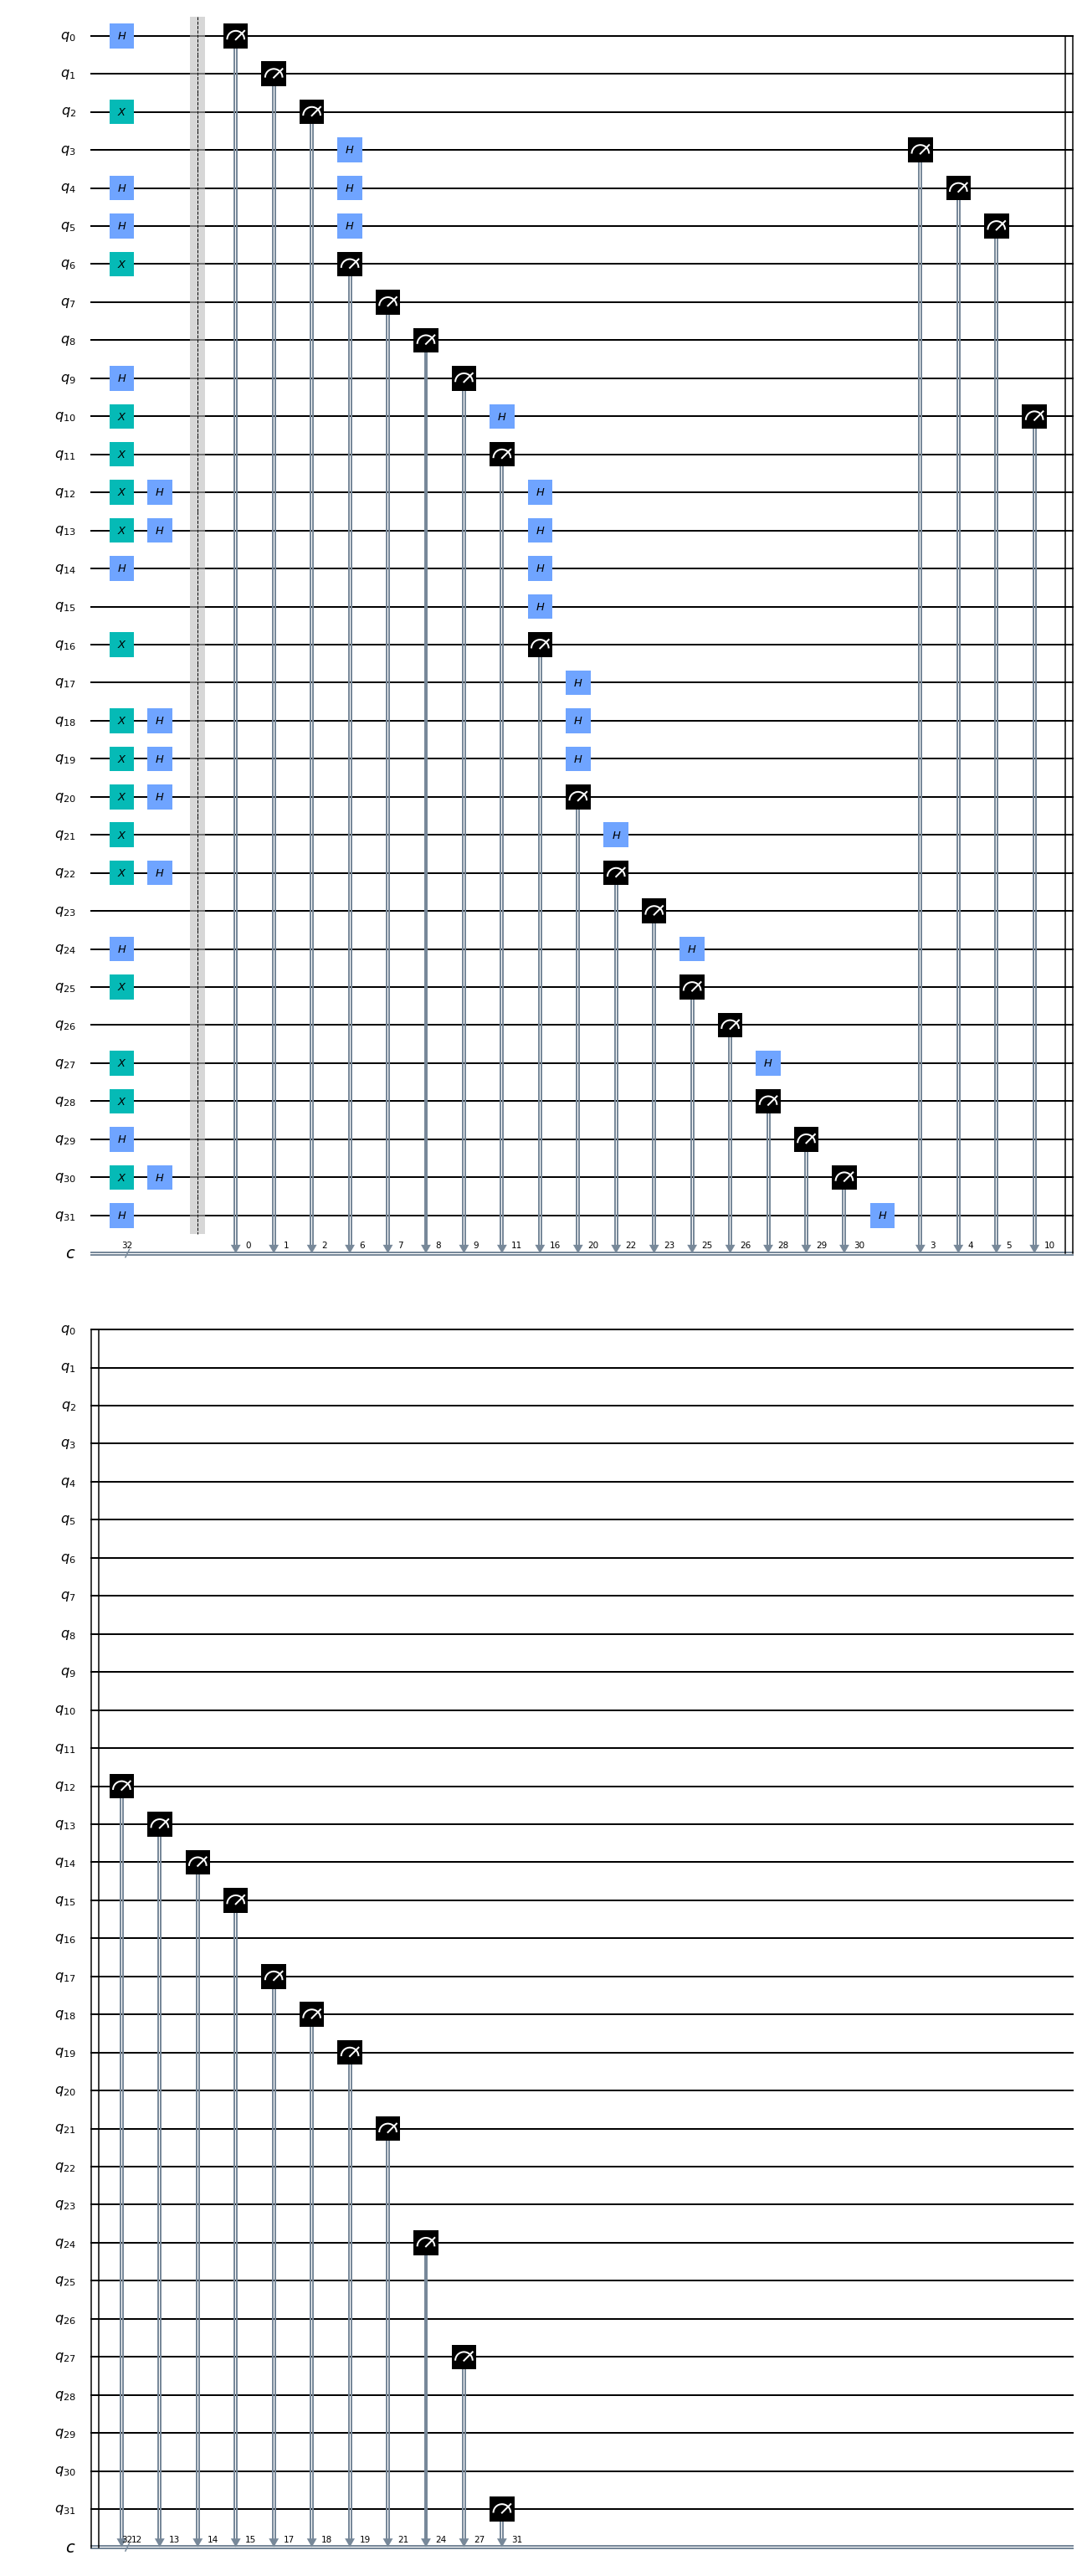

In [22]:
#Step 4 - Ram encodes his bits in the chosen bases 
ram_encode = encode_bits(ram_bits, ram_bases)

#Step 5 - Ram sends his encoded bits to Sita and Ravan tries to intercept over the Quantum channel
received_encode = QCC(ram_encode)

#Step 6 - Sita measures Ram's bits in the chosen bases
sita_circuit, sita_bits = measure_bits(received_encode, sita_bases)
print(sita_bits)

#Step 7 - Sita announces that she has received the encoding and measured it over CAC

#Step 8 - Ram and Sita exchange their bases over CAC
r2s = CAC(ram_bases)
s2r = CAC(sita_bases)

#Step 9 - Ram and Sita discard all the bits that correspond to disagreed bases
agreed_base_indices = agreed_bases(ram_bases, sita_bases)
print(agreed_base_indices)
sita_circuit.draw(output = 'mpl')

|Information|Dev|Kaal|Abhi|
|:-:|:-:|:-:|:-:|
|Dev's Encoding|Y|Partial|Noisy|
|Abhi's bits|N|N|Y|
|Dev's and Abhi's bases|Y|Y|Y|

In [26]:
#Step 10 - Error rate checking 
S2T = bit_string(len(agreed_base_indices))
T = select_bits(agreed_base_indices, S2T, 0)

#Step 11 - Ram tells T to Sita over CAC
sita_T = CAC(T)

#Step 12 - Ram and Sita generate their test bits 
ram_test_bits, sita_test_bits = [], []
for i in T :
    ram_test_bits.append(ram_bits[i])
    sita_test_bits.append(sita_bits[i])

#Step 12 - Ram and Sita announce their test bits to each other over the CAC

#Step 13 - Ram and Sita compute the error rate
error = error_rate(ram_test_bits, sita_test_bits)
print(error)

0.0


|Information|Dev|Kaal|Abhi|
|:-:|:-:|:-:|:-:|
|T|Y|Y|Y|
|Dev's test bits|Y|Y|Y|
|Abhi's test bits|Y|Y|Y|

In [27]:
#Step 14 - Ram and Sita check over a threshold for error before proceeding ahead
if error > 0.11 :
    print ("Abort")
else :
    #Step 15 - Ram and Sita generate their pseudo keys
    SminusT = select_bits(agreed_base_indices, S2T, 1)
    ram_pseudokey, sita_pseudokey = [], []
    for i in SminusT :
        ram_pseudokey.append(ram_bits[i])
        sita_pseudokey.append(sita_bits[i])

    #Step 16 - Ram and Sita perform Information Reconciliation
    ram_reconcile = ram_pseudokey
    sita_reconcile = sita_pseudokey

    #Step 17 - Ram and Sita perform privacy amplification
    n, k = len(ram_reconcile), len(ram_reconcile) // 2
    seed = bit_string(n + k - 1)
    ram_key = toeplitz(n, k, ram_reconcile, seed)
    sita_key = toeplitz(n, k, sita_reconcile, seed)

|Information|Dev|Kaal|Abhi|
|:-:|:-:|:-:|:-:|
|Pseudo key|Y|Partial|Noisy|